In [41]:
import pandas as pd
import seaborn as sns
from datetime import datetime
from SparseSC import fit
sns.set(rc={'figure.figsize':(11.7,8.27)})
import numpy as np
#From Causal Inference Facures book online
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [42]:
#manually compiled these: comprises of "best of 2023" economics, politics, & history
list_of_treated_ids = [
    130758645,
    62217087,
    62192405, 
    193907194,
    61282598,
    62847908,
    61884887,
    62121704,
    75657079,
    61898069,
    61089447,
    96177657,
    111172404,
    120532418,
    75495020,
    61349852,
    77920745,
    199542911,
    63326676,
    62347050,
    61327508,
    61813215,
    123199472,
    112976346,
    62874267,
    123993293,
    61898079,
    122773797,
    62927217,
    197693246,
    188547135,
    177281779,
    62347058,
    63933739,
    90663680,
    123831773,
    123436434,
    62792704,
    62921469,
    86532647,
    65211868,
    75560036
]

In [124]:
df = pd.read_csv('books_data_new_try.csv')
df['treated'] = df['book_id'].map(lambda x: True if x in list_of_treated_ids else False)
df['added_and_to_read'] = df['added'] + df['to-read']
df['date'] = pd.to_datetime(df['date'])
df['identifier'] = df.apply(lambda x: 'treated' if x.treated==1 else str(x.book_id), axis=1)
print(df['date'].max())
print(df['date'].min())
#df = df[(df['date'] <= '2023-12-30') & (df['date'] >= '2023-01-04')]
print(df['date'].max())
print(df['date'].min())
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)
print(df.book_id.nunique())
print(df.head())

2024-01-04 00:00:00
2023-07-19 00:00:00
2024-01-04 00:00:00
2023-07-19 00:00:00
(57460, 9)
(50497, 9)
297
        date  added  ratings  reviews  to-read    book_id  treated  \
0 2023-07-19      0        0        0        0  130758645     True   
1 2023-07-20      1        0        0        1  130758645     True   
2 2023-07-21      0        0        0        0  130758645     True   
3 2023-07-22      0        0        0        0  130758645     True   
4 2023-07-23      0        0        0        0  130758645     True   

   added_and_to_read identifier  
0                  0    treated  
1                  2    treated  
2                  0    treated  
3                  0    treated  
4                  0    treated  


In [125]:
#Remove a few outliers...? if they have 200+ add/to-read ever, exclude them -- takes out about 10 books and heavily increases our model's accuracy, it seems like  
df = df[df.groupby('book_id')['added_and_to_read'].transform('max').between(0,200)]


In [126]:
#group by treated & untreated
#df.head()
grouped_treated = df.groupby(['date', 'identifier']).agg({'added_and_to_read': 'mean'}).reset_index() #, 'book_id': 'nunique'
grouped_treated#.head()

,date,identifier,added_and_to_read
0,2023-07-19,102705141,0.000000
1,2023-07-19,106014,0.000000
2,2023-07-19,1067170,0.000000
3,2023-07-19,108693205,0.000000
4,2023-07-19,110572,0.000000
...,...,...,...
43515,2024-01-04,95643,36.000000
43516,2024-01-04,95960,0.000000
43517,2024-01-04,9596303,0.000000
43518,2024-01-04,980472,0.000000


In [127]:
#plot
#sns.lineplot(x='date', y='added_and_to_read', hue='identifier', data=grouped_treated)

In [128]:
#sns.lineplot(x='date', y='added_and_to_read', data=df)
#df[df['added_and_to_read'] > 100].book_id.unique()

#books to potentially exclude bc of exogenous stuff in our time period of plus/minus 45 days: 61884887 (middle east war popped off), 

In [129]:
#df['identifier'] = df.apply(lambda x: 'treated' if x.treated==1 else str(x.book_id), axis=1)
#df

In [130]:
data = grouped_treated.pivot(index='identifier', columns='date')['added_and_to_read'].T
before_data = data[data.index < '2023-11-15']
#before_data
X = before_data.iloc[:,:-1].values
X
y = before_data.iloc[:,-1].values
y

array([ 3.52941176,  3.58823529,  3.85294118,  4.41176471,  5.64705882,
        4.73529412,  4.76470588,  5.70588235,  3.73529412,  3.35294118,
        4.05882353,  3.26470588,  3.11764706,  3.55882353,  2.64705882,
        3.23529412,  4.61764706,  4.11764706,  6.44117647,  4.55882353,
        4.82352941,  4.91176471,  4.17647059,  4.        ,  4.20588235,
        6.23529412,  6.02941176,  4.32352941,  3.61764706,  3.97058824,
        2.61764706,  3.85294118,  4.64705882,  5.67647059,  4.32352941,
        4.        ,  2.88235294,  3.14705882,  3.44117647,  3.82352941,
        4.05882353,  4.79411765,  3.38235294,  4.20588235,  3.58823529,
        4.41176471,  3.79411765,  4.08823529,  3.32352941,  4.82352941,
        3.52941176,  4.02941176,  4.85294118,  5.88235294,  4.88235294,
        3.38235294,  3.55882353,  4.        ,  4.        ,  4.64705882,
        4.76470588,  4.58823529,  4.02941176,  3.97058824,  3.91176471,
        4.73529412,  4.32352941,  4.17647059,  3.58823529,  9.26

In [131]:
ws = get_w(X,y)
#len(ws)
synth_series = data.iloc[:, :-1].values.dot(ws)
treated = data.iloc[:, -1].values

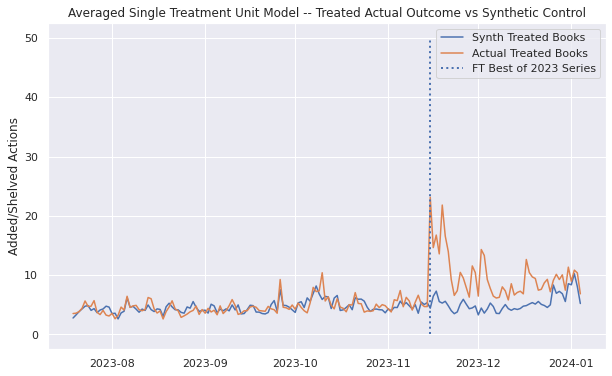

In [133]:
from matplotlib import style
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(data.index,synth_series, label="Synth Treated Books")
plt.plot(data.index,treated, label="Actual Treated Books")
plt.vlines(x=pd.to_datetime('2023-11-15'), ymin=0, ymax=50, linestyle=":", lw=2, label="FT Best of 2023 Series")
plt.ylabel("Added/Shelved Actions")
plt.title("Averaged Single Treatment Unit Model -- Treated Actual Outcome vs Synthetic Control")
plt.legend();

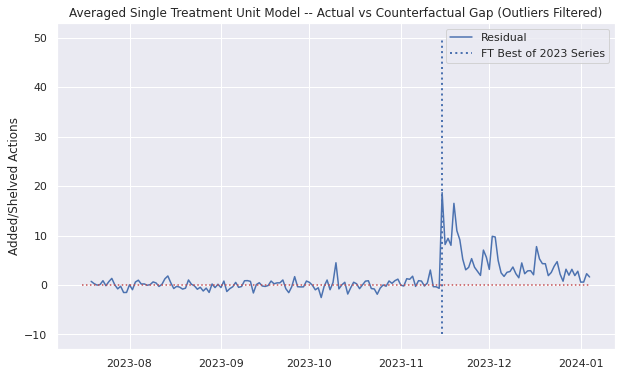

In [92]:
residual = treated-synth_series
plt.figure(figsize=(10,6))
plt.plot(data.index,residual, label="Residual")
plt.vlines(x=pd.to_datetime('2023-11-15'), ymin=-10, ymax=50, linestyle=":", lw=2, label="FT Best of 2023 Series")
plt.hlines(y=0, xmin=pd.to_datetime('2023-07-16') , xmax=pd.to_datetime('2024-01-04'),linestyle=":", color='r')
#plt.title("Averaged Single Treatment Unit Model -- Actual vs Counterfactual Gap") 
plt.title("Averaged Single Treatment Unit Model -- Actual vs Counterfactual Gap (Outliers Filtered)") 

plt.ylabel("Added/Shelved Actions")
plt.legend()

In [117]:
df.book_id.nunique() #.pivot(index=['book_id', 'treated'], columns='date') #['added_and_to_read'] #.query("treated==True")
test = df.groupby(['book_id']).size()#.value_counts()


#62121704    
#62192405
df = df.drop_duplicates(subset=['date', 'book_id'])
test = df[df['book_id'].isin([62121704,62192405])]
test.groupby(['book_id']).agg({'date': ['min', 'max', 'count']})
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(test)
#test[test.groupby(level=0).transform('count') > 1]
#[x for x in test.tolist() if x != 170] #!!

date                 
                min        max count
book_id                             
62121704 2023-07-19 2024-01-04   170
62192405 2023-07-19 2024-01-04   170

In [118]:
#Now, what if I estimate separate synthetic controls for each & aggregate, as opposed to averaging?
#See discussion here: https://stats.stackexchange.com/questions/616939/synthetic-control-method-based-on-several-treated-units
deagg_ys = df.pivot(index=['book_id', 'treated'], columns='date')['added_and_to_read'].query("treated==True").T
deagg_Xs = df.pivot(index=['book_id', 'treated'], columns='date')['added_and_to_read'].query("treated==False").T
pre_deagg_ys = deagg_ys[deagg_ys.index < '2023-11-15']
pre_deagg_Xs = deagg_Xs[deagg_Xs.index < '2023-11-15']
#pre_deagg_Xs

weights = []
synth_pred_series = []
for yname,y in pre_deagg_ys.items():
    print(yname)
    ws = get_w(pre_deagg_Xs,y)
    synth_series = deagg_Xs.values.dot(ws)
    #print(synth_series)
    weights.append(ws)
    synth_pred_series.append(synth_series)
print(len(weights))

(61089447, True)
(61282598, True)
(61327508, True)
(61349852, True)
(61813215, True)
(61884887, True)
(61898069, True)
(61898079, True)
(62121704, True)
(62192405, True)
(62217087, True)
(62347050, True)
(62347058, True)
(62792704, True)
(62847908, True)
(62874267, True)
(62921469, True)
(62927217, True)
(63326676, True)
(63933739, True)
(65211868, True)
(86532647, True)
(111172404, True)
(112976346, True)
(120532418, True)
(122773797, True)
(123831773, True)
(123993293, True)
(130758645, True)
(177281779, True)
(188547135, True)
(193907194, True)
(197693246, True)
(199542911, True)
34


In [119]:
#deagg_ys
#len(deagg_ys.sum(axis=1).tolist())
np.asarray(synth_pred_series).T.sum(axis=1)

array([119.98848654, 123.71284134, 147.93797196, 174.44019021,
       157.20800787, 159.16384014, 163.95648338, 173.41306428,
       148.49299851, 141.32328638, 145.88795345, 185.63608429,
       182.00002236, 129.68415097, 152.46533983, 114.17861551,
       126.84899652, 154.97140079, 233.64012852, 153.15240022,
       171.85156084, 163.43081569, 129.14771008, 156.33466064,
       158.6228002 , 164.01911078, 149.49490829, 127.09927844,
       142.05704468, 156.02910042, 105.6805604 , 157.90517114,
       192.11533299, 153.19000156, 127.60584149, 149.74883409,
       162.37105148, 142.32494182, 181.86308942, 185.16542242,
       187.94266801, 161.63715454, 136.96581693, 157.84603567,
       143.61716788, 141.15280212, 162.19005317, 179.89183945,
       121.82483469, 144.19813674, 137.3899647 , 137.47675618,
       139.85647313, 174.27601801, 125.0448023 , 122.00403832,
       102.22851702, 116.37754656, 132.97572386, 161.46980294,
       149.04206749, 111.62218359, 133.71618398, 125.20

[119.98848654 123.71284134 147.93797196 174.44019021 157.20800787
 159.16384014 163.95648338 173.41306428 148.49299851 141.32328638
 145.88795345 185.63608429 182.00002236 129.68415097 152.46533983
 114.17861551 126.84899652 154.97140079 233.64012852 153.15240022
 171.85156084 163.43081569 129.14771008 156.33466064 158.6228002
 164.01911078 149.49490829 127.09927844 142.05704468 156.02910042
 105.6805604  157.90517114 192.11533299 153.19000156 127.60584149
 149.74883409 162.37105148 142.32494182 181.86308942 185.16542242
 187.94266801 161.63715454 136.96581693 157.84603567 143.61716788
 141.15280212 162.19005317 179.89183945 121.82483469 144.19813674
 137.3899647  137.47675618 139.85647313 174.27601801 125.0448023
 122.00403832 102.22851702 116.37754656 132.97572386 161.46980294
 149.04206749 111.62218359 133.71618398 125.20962247 126.76830858
 120.2683215  158.36927442 187.49029742 132.50560187 207.50629831
 165.58457754 134.42024825 144.91790138 142.10769249 147.39051908
 149.7313655

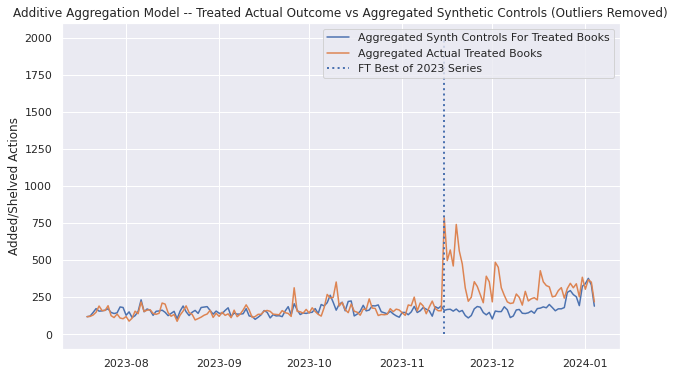

In [135]:
#plot it out and try to aggregate

#aggregated synth predictions & actual
agg_ys = deagg_ys.sum(axis=1).tolist()
#print(synth_pred_series)
agg_synths = np.asarray(synth_pred_series).T.sum(axis=1) #np.asarray(synth_pred_series).sum(axis=1)
print(agg_synths)
print(len(agg_synths))
print(deagg_ys.index)
plt.figure(figsize=(10,6))
#plt.plot(deagg_ys.index, synth_pred_series[0], label="Example 1 Singuler Synth Control")
#plt.plot(deagg_ys.index, synth_pred_series[1], label="Example 2 Singuler Synth Control")
plt.plot(deagg_ys.index, agg_synths, label="Aggregated Synth Controls For Treated Books")
plt.plot(deagg_ys.index, agg_ys, label="Aggregated Actual Treated Books")
plt.vlines(x=pd.to_datetime('2023-11-15'), ymin=0, ymax=2000, linestyle=":", lw=2, label="FT Best of 2023 Series")
plt.ylabel("Added/Shelved Actions")
plt.title("Additive Aggregation Model -- Treated Actual Outcome vs Aggregated Synthetic Controls (Outliers Removed)")
plt.legend();